## Optimise weights for it0 docking to match No-AIR HADDOCK scores from it0

In [1]:
%%script false --no-raise-error
import numpy as np
import pandas as pd
import scipy as sp
noair_it1 = np.genfromtxt('../conf10_160/run1/structures/it1/it1enenoair_name-sorted.txt')

''' df is a file from it0 containing individual score terms'''
df = pd.read_csv('it0structures_name-sorted.txt', delimiter=",")

''' weights of Evdw, Eelec, Edesolv, bsa'''
weights = np.array([0.01, 1.0, 1.0, -0.01])

'''Write noair scores to pandas and numpy'''
df["Enoair"] = weights[0]*df["Evdw"] + weights[1]*df["Eelec"] + weights[2]*df["Edesolv"] + weights[3]*df["bsa"] 
noair_it0 = df["Enoair"].to_numpy()

corr, _ = sp.stats.pearsonr(noair_it0, noair_it1)
corr

In [2]:
%%script false --no-raise-error
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sb

noair_it1 = np.genfromtxt('it1enenoair_name-sorted.txt')
df = pd.read_csv('it0structures_name-sorted.txt', delimiter=",")

def noair_it0(w):    
    return (w[0]*df["Evdw"] + w[1]*df["Eelec"] + w[2]*df["Edesolv"] + w[3]*df["bsa"]).to_numpy() 

def corr_it0_it1(w):    
    df["Enoair"] = w[0]*df["Evdw"] + w[1]*df["Eelec"] + w[2]*df["Edesolv"] + w[3]*df["bsa"] 
    noair_it0 = df["Enoair"].to_numpy()
    corr, _ = stats.pearsonr(noair_it0, noair_it1)
    return 1-corr

weights = np.array([0.01, 1.0, 1.0, -0.01])
res = minimize(corr_it0_it1, weights, method='nelder-mead',options={'xatol': 1e-8, 'disp': True})
print(res.x)

sb.set_context("poster")
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12, 12))
plt.scatter(noair_it0(res.x),noair_it1)
plt.xlabel('it0 E_noair')
plt.ylabel('it1 E_noair')

Optimization terminated successfully.
         Current function value: 0.324913
         Iterations: 224
         Function evaluations: 444
[-0.00235625  1.84300581 -1.09260373 -0.03187086]


Text(0, 0.5, 'it1 E_noair')

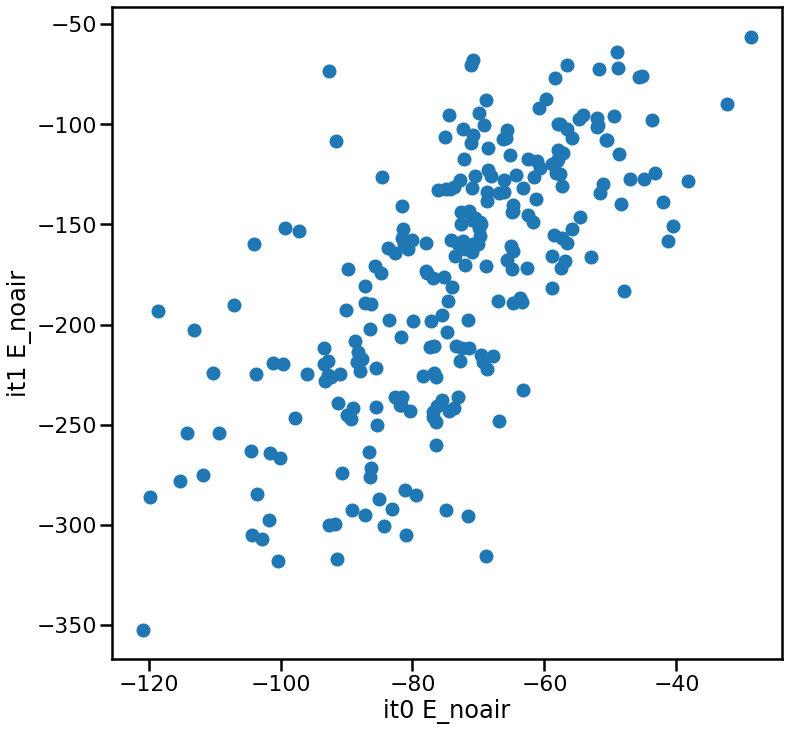

In [34]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sb

top = 250 # select on  how many lowest scoring values you want to fit the data

noair_it1 = np.genfromtxt('../conf10_260/run1/structures/it1/it1enenoair_name-sorted.txt')
noair_it1_ind = np.argsort(noair_it1)
noair_it1 = np.sort(noair_it1)[:top]

df = pd.read_csv('../conf10_260/run1/structures/it0/it0structures_name-sorted.txt', delimiter=",")

def noair_it0(w):    
    v = (w[0]*df["Evdw"] + w[1]*df["Eelec"] + w[2]*df["Edesolv"] + w[3]*df["bsa"]).to_numpy() 
    return v[noair_it1_ind][:top]
    
def corr_it0_it1(w):    
    corr, _ = stats.pearsonr(noair_it0(w), noair_it1)
    return 1-corr

weights = np.array([0.01, 1.0, 1.0, -0.01])
res = minimize(corr_it0_it1, weights, method='nelder-mead',options={'xatol': 1e-8, 'disp': True, 'maxiter':10000, 'adaptive':True})
print(res.x)

sb.set_context("poster")
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12, 12))
plt.scatter(noair_it0(res.x),noair_it1)
plt.xlabel('it0 E_noair')
plt.ylabel('it1 E_noair')

## Make a for loop for all the docked complexes

In [ ]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sb

!rm coeff_optimised.txt function_evaluation.txt *.jpg
with open("../list.txt") as list:
    files = list.readlines()
    for line in files:
        top = 250 # select on  how many lowest scoring values you want to fit the data

        noair_it1 = np.genfromtxt('../'+line.strip()+'/run1/structures/it1/it1enenoair_name-sorted.txt')
        noair_it1_ind = np.argsort(noair_it1)
        noair_it1 = np.sort(noair_it1)[:top]

        df = pd.read_csv('../'+line.strip()+'/run1/structures/it0/it0structures_name-sorted.txt', delimiter=",")

        def noair_it0(w):    
            v = (w[0]*df["Evdw"] + w[1]*df["Eelec"] + w[2]*df["Edesolv"] + w[3]*df["bsa"]).to_numpy() 
            return v[noair_it1_ind][:top]
    
        def corr_it0_it1(w):    
            corr, _ = stats.pearsonr(noair_it0(w), noair_it1)
            return 1-corr

        weights = np.array([0.01, 1.0, 1.0, -0.01])
        res = minimize(corr_it0_it1, weights, method='nelder-mead',options={'xatol': 1e-8, 'disp': True, 'maxiter':10000, 'adaptive':True})

        sb.set_context("poster")
        plt.rcParams.update({'font.size': 22})
        plt.figure(figsize=(12, 12))
        plt.scatter(noair_it0(res.x),noair_it1)
        plt.xlabel('it0 E_noair')
        plt.ylabel('it1 E_noair')
        plt.title(line)
        plt.savefig(line.strip()+'.jpg', dpi=300, transparent=True)
        
        with open("coeff_optimised.txt", 'a') as file1:
            np.savetxt(file1,res.x, fmt='%.3f', newline=',')
            file1.write("\n")
        
        with open("function_evaluation.txt", 'a') as file2:
            file2.writelines(np.array2string(res.fun))
            file2.write("\n")

## Find the best fit coefficients

In [52]:
import numpy as np

spearmanr = 1 - np.genfromtxt('function_evaluation.txt')
coefficients = np.genfromtxt('coeff_optimised.txt', delimiter=',')[:,:-1]

scaled_coefficients = spearmanr[:,None]*coefficients
average_coefficients = np.sum(scaled_coefficients,0)/np.sum(spearmanr)
np.savetxt('avg_coeff.txt',average_coefficients, newline=',', fmt='%.5f')

std_dev = np.std(scaled_coefficients, 0)
np.savetxt('std_coeff.txt', std_dev, newline=',', fmt='%.5f')